# SWE bench Solver Agentic Workflow

In [5]:
from langgraph.graph import StateGraph, END, MessagesState, add_messages
from typing import TypedDict, Annotated, Sequence
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, FunctionMessage, AnyMessage, ToolMessage
from langgraph.prebuilt import ToolExecutor, ToolInvocation, ToolNode
from langchain_core.runnables import RunnableConfig
from app.tools import *
from time import time
import re, operator, json, git


In [ ]:
OPENAI_API_KEY = ""
GROQ_API_KEY = ''

### Defining LLMs & Tool Nodes

In [7]:
model = "gpt-4o-mini"

search_llm = ChatOpenAI(
    model=model,
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=OPENAI_API_KEY, 
)

extractor_llm = ChatOpenAI(
    model=model,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=OPENAI_API_KEY, 
)

# patch_llm = ChatGroq(
#     api_key=GROQ_API_KEY, 
#     # model='llama-3.2-90b-text-preview', 
#     # model='llama-3.1-70b-versatile',
#     model='llama-3.1-8b-instant',
#     max_tokens=1024,
#     temperature=0.0,
# )

patch_llm = ChatOpenAI(
    model=model,
    temperature=0.1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=OPENAI_API_KEY, 
)

patch_debugger_llm = ChatOpenAI(
    model=model,
    temperature=0.5,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=OPENAI_API_KEY, 
)

patch_debugger_llm = patch_debugger_llm.bind_tools(getContentViewingTools())
search_llm = search_llm.bind_tools(getSearchTools())
extractor_llm = extractor_llm.bind_tools(getContentViewingTools())

search_tool_node = ToolNode(tools=getSearchTools())
extract_code_tool_node = ToolNode(tools=getContentViewingTools())

### Defining Graph State

In [8]:
class PatchState(TypedDict):
    patch: str
    code: str
    example_patch: str
    data: dict
    repo: str
    patch_application_failures: int
    messages: Annotated[list[AnyMessage], add_messages]

### Prompting

In [9]:
search_issue_code_prompt = PromptTemplate.from_template("""
You have been provided some tools to access the files of {repo} repository. You are currently in the {cwd} directory. You will be provided with an issue. Your task is to pin-point those files with line numbers from the repository that are likely to cause that issue.

Problem Statement: {issue}

Hint: {hint} 

Use tool calls only if necessary. You are only allowed to use one most appropriate tool at a time. Call the tool you think is the most appropriate one and let the tols supply its output to the next agent. The next agent will continue to use more tools as necessary.
                                                        
Remember to only use one most appropriate tool. If you don't know about the directories or files in the current directories, use 'ls' tool to list them.                          

Only provide the file paths and the line numbers that are the cause of this issue in the format:
File: ... Line: ...
File: ...           
                                                    
""")

# -------------------------------------------------------------------------------------

extract_content_from_files_prompt = PromptTemplate.from_template("""
These are the files with lines of code. 
{files}
                                                                 
Use the tools provided to you to provide the contents of these files strating from the line numbers. Remember currently you are in {current_dir} directory.                                                              
""")

# -------------------------------------------------------------------------------------

generate_patch_prompt_template = """
You are a highly skilled software engineer specialized in fixing complex coding issues from GitHub repositories. Your task is to provide a python patch for a problem in the format of git diff that can be directly applied using git apply to a git repository.

This is the problem statement of the issue:
{problem_statement}

This is the relevant code related to the issue
{code}

Here is an example of a patch file. It consists of changes to the code base. It specifies the file names, the line numbers of each change, and the removed and added lines. A single patch file can contain changes to multiple files.

{example_patch}

Your task is to generate a single patch file to this issue, similar to the example provided. It should be in a format that can be applied directly to the repository using `git apply`. Don't include any introductory or explainatory text. Don't encapsulate your answer in ```..```. Your patch file must start with diff --git.
"""

# -------------------------------------------------------------------------------------

patch_debug_prompt = PromptTemplate.from_template("""
You are a highly skilled software engineer specialized in code reviewing. You have been provided with a patch.diff file that is supposed to be applied to a git repository. This patch conatins some syntax errors or its line numbers or line contents are not matching with original code due to which it is failing to apply.

Patch file: 
{patch}
                                                  
Original Code on which patch is to be applied:
{code}

Error on applying patch:
{error}

Your task is to correct the errors in the patch file so that it can be successfully applied to the repository. Provide the corrected patch file in the same format as the original patch file. Don't include any introductory or explainatory text. Don't encapsulate your answer in ```..```. 
Try to add '\n' at the end of the file if the patch fails. Try to match the whitespaces and indentation as closely as possible from the originial file. Don't add anything extra to the patch. Only correct the errors. If your patch fails, it means that the contents of the patch referring to the original file are incorrect. Also strictly match any empty lines from original code also. If you think you don't have contents of the files that are being modified, use the tools provided to you to get the contents of those files. But remember to avoid using tools as much as possible.
""")

### Defining Agents

In [10]:
# Agents -------------------------------------------------------------------------------------

def extract_data(state: PatchState):
    # state['code'] = re.search(r'<code>(.*?)</code>', state['data']['text'], re.DOTALL).group(1).strip()
    state['example_patch'] = re.search(r'<patch>(.*?)</patch>', state['data']['text'], re.DOTALL).group(1).strip()
    print(f"{state['data']['instance_id']}: Data extraction complete")
    return state

def search_issue_code(state: PatchState):
    messages = state['messages']
    response = search_llm.invoke(messages)
    return {
        **state,
        "messages": [response]
    }

def should_use_search_tool(state: PatchState):
    messages = state['messages']
    last_message = messages[-1]
    if 'tool_calls' not in last_message.additional_kwargs:
        return 'end'
    return 'continue'

def extract_content_from_files(state: PatchState):
    message = state['messages'][-1]
    directory.cwd = f"/{state['repo']}/"
    response = extractor_llm.invoke([extract_content_from_files_prompt.format(files=message.content, current_dir=directory.cwd)])
    print(f"{state['data']['instance_id']}: Got error related files")
    return {
        **state,
        "messages": [response]
    }

def generate_patch(state: PatchState):
    for i in range(len(state['messages'])-1, 0, -1):
        if isinstance(state['messages'][i], AIMessage):
            break
        state['code'] += state['messages'][i].content
    prompt = PromptTemplate.from_template(generate_patch_prompt_template)
    llm_chain = prompt | patch_llm 
    response = llm_chain.invoke({"problem_statement": state['data']['problem_statement'], "code": state['code'], "example_patch": state['example_patch']})
    state['patch'] = response.content
    with open(f"test-repos/{state['repo']}/patch.diff", "w") as f:
        f.write(state['patch'])
    
    print(f"{state['data']['instance_id']}: Patch Generated")
    return {
        **state,
        "messages": [response]
    }

def apply_patch(state: PatchState):
    directory.cwd = f"/{state['repo']}/"
    cm_output = shell.run({"commands": [
        f"cd test-repos/{state['repo']}",
        f"git apply patch.diff --ignore-whitespace -v",
    ]})
    print(f"{state['data']['instance_id']}: {cm_output}")
    shell.run({"commands": [
        f"cd test-repos/{state['repo']}",
        f"git restore"
    ]})
    if 'error' in cm_output:
        state['patch_application_failures'] += 1
    return {
        **state,
        "messages": [FunctionMessage(content=cm_output, name='Patch_Application_Output')]
    }

def should_debug_patch(state: PatchState):
    cm_output = state['messages'][-1].content
    if 'Applied patch' in cm_output:
        return 'end'
    if state['patch_application_failures'] > 3:
        return 'end'
    return 'correct_errors'

def debug_patch(state: PatchState):
    messages = []
    for i in range(len(state['messages'])-1, 0, -1):
        if isinstance(state['messages'][i], FunctionMessage):
            apply_patch_message = state['messages'][i]
            break
        messages.append(state['messages'][i])
    
    messages.reverse()
    
    if not isinstance(state['messages'][-1], ToolMessage):
        messages.append(HumanMessage(content=patch_debug_prompt.format(patch=state['patch'], error=apply_patch_message.content, code=state['code']), name='Correct_Patch'))

    response = patch_debugger_llm.invoke(messages)
    
    if response.content != "":
        state['patch'] = response.content
        with open(f"test-repos/{state['repo']}/patch.diff", "w") as f:
            f.write(state['patch'])
    
    print(f"{state['data']['instance_id']}: Debug patch attempt {state['patch_application_failures']}")

    return {
        **state,
        "messages": messages + [response]
    }

### Defining Graph Architecture

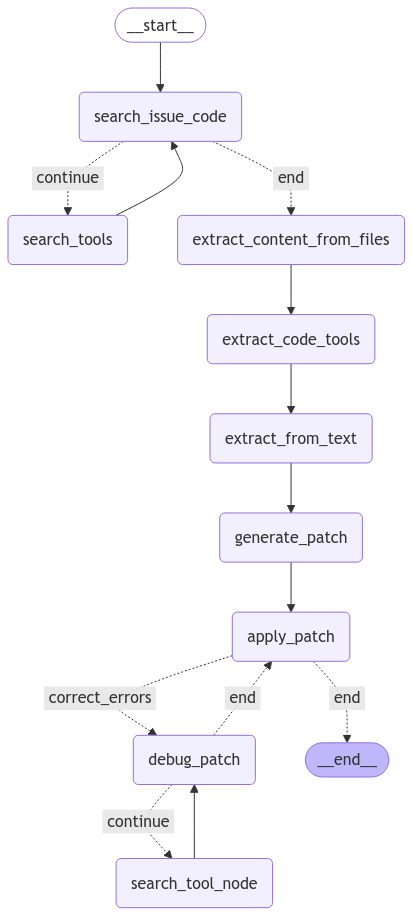

In [11]:
workflow = StateGraph(PatchState)

workflow.add_node("search_issue_code", search_issue_code)
workflow.add_node("search_tools", search_tool_node)
workflow.add_node("extract_content_from_files", extract_content_from_files)
workflow.add_node("extract_code_tools", extract_code_tool_node)
workflow.add_node('extract_from_text', extract_data)
workflow.add_node("generate_patch", generate_patch)
workflow.add_node("apply_patch", apply_patch)
workflow.add_node("debug_patch", debug_patch)
workflow.add_node('search_tool_node', extract_code_tool_node)

workflow.set_entry_point('search_issue_code')

workflow.add_conditional_edges(
    'search_issue_code',  
    should_use_search_tool,
    {
        'continue': 'search_tools',
        'end': 'extract_content_from_files'
    }
)

workflow.add_edge("search_tools", "search_issue_code")
workflow.add_edge("extract_content_from_files", "extract_code_tools")
workflow.add_edge("extract_code_tools", "extract_from_text")
workflow.add_edge("extract_from_text", "generate_patch")
workflow.add_edge("generate_patch", "apply_patch")

workflow.add_conditional_edges(
    'apply_patch',  
    should_debug_patch,
    {
        'correct_errors': 'debug_patch',
        'end': END
    }
)

workflow.add_conditional_edges(
    'debug_patch',
    should_use_search_tool,
    {
        'continue': 'search_tool_node',
        'end': 'apply_patch'
    }
)

workflow.add_edge("search_tool_node", "debug_patch")

app = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass


### Getting Dataset

In [8]:
from datasets import load_dataset

# dataset = load_dataset(path="ahsanirfan961/swe-bech-lite-bm25-13k-take3", split='train')
dataset = load_dataset(path="ahsanirfan961/swe-bech-lite-bm25-13k-take50", split='train')
# dataset = dataset.select(range(1, 2))
dataset

README.md:   0%|          | 0.00/753 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

Dataset({
    features: ['instance_id', 'text', 'repo', 'base_commit', 'problem_statement', 'hints_text', 'created_at', 'patch', 'test_patch', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit'],
    num_rows: 50
})

### Running the workflow

In [9]:
predictions = []
logs = {
    "total": len(dataset),
    "generated": 0,
    "resolved_count": 0,
    "resolved_with_errors_count": 0,
    "resolved": [],
    "resolved_with_errors": [],
    "generation_errors": [],
    "generation_time_in_seconds": []
}

print(f"Generating predictions for {len(dataset)} instances")
for i, data in enumerate(dataset):
    start_time = time()
    try:
        print(f"Generating patch for {i+1}/{len(dataset)} instance")
        repo_name = data['repo'].split('/')[-1]
        setup_repo(data)
        initial_state = {
            "messages": [HumanMessage(content=search_issue_code_prompt.format(repo=repo_name, cwd=directory.cwd, issue=data['problem_statement'], hint=data['hints_text']))],
            "patch": "",
            "code": "",
            "example_patch": "",
            "patch_application_failures": 0,
            "repo": repo_name,
            "data": data
        }

        # for chunk in app.stream(initial_state, stream_mode="values", config=RunnableConfig(recursion_limit=100)):
        #     chunk["messages"][-1].pretty_print()

        output: PatchState = app.invoke(initial_state, config=RunnableConfig(recursion_limit=100))

        # for message in output['messages']:
        #     message.pretty_print()

        if "Applied patch" in output['messages'][-1].content:
            logs['resolved_count'] += 1
            logs['resolved'].append(data['instance_id'])
        else:
            logs['resolved_with_errors_count'] += 1
            logs['resolved_with_errors'].append(data['instance_id'])
        logs['generated'] += 1

        predictions.append({
            "instance_id": data['instance_id'],
            "model_name_or_path": "gpt-4o-mini",
            "model_patch": output['patch']
            })
        
        trajs = []
        for message in output['messages']:
            trajs.append({
                message.name: message.content
            })
        json.dump(trajs, open(f"outputs/trajs/{data['instance_id']}.json", "w"))
    
    except Exception as e:
        logs['generation_errors'].append({
            "instance_id": data['instance_id'],
            "error": str(e)
        })
        print(e)
        print(f"Error while generating patch for {data['instance_id']}")
        continue
    end_time = time()
    logs['generation_time_in_seconds'].append({
        "instance_id": data['instance_id'],
        "time": end_time - start_time
    })
    
json.dump(logs, open("outputs/logs.json", "w"))
json.dump(predictions, open("outputs/predictions.json", "w"))
    

Generating predictions for 50 instances
Generating patch for 1/50 instance
Executing command:
 ['cd test-repos', 'git config --global http.postBuffer 524288000', 'git clone https://github.com/astropy/astropy.git']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Cloning into 'astropy'...
Updating files: 100% (1952/1952), done.

Executing command:
 ['cd test-repos/astropy', 'git checkout -b astropy__astropy-14365 7269fa3e33e8d02485a647da91a5a2a60a06af61']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'astropy__astropy-14365'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'cd astropy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/astropy/', 'cd io']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/astropy/io/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/astropy/io/', 'cd ascii']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/astropy/io/ascii/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/astropy/io/ascii/', 'cd tests']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/astropy/io/ascii/tests/', 'ls']
astropy__astropy-14365: Got error related files
astropy__astropy-14365: Data extraction complete
astropy__astropy-14365: Patch Generated
Executing command:
 ['cd test-repos/astropy', 'git apply patch.diff --ignore-whitespace -v']
astropy__astropy-14365: error: patch fragment without header at line 16: @@ -46,7 +46,7 @@ def test_roundtrip(tmp_path):

Executing command:
 ['cd test-repos/astropy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


astropy__astropy-14365: Debug patch attempt 1
astropy__astropy-14365: Debug patch attempt 1
Executing command:
 ['cd test-repos/astropy', 'git apply patch.diff --ignore-whitespace -v']
astropy__astropy-14365: error: patch fragment without header at line 16: @@ -46,7 +46,7 @@ def test_roundtrip(tmp_path):

Executing command:
 ['cd test-repos/astropy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


astropy__astropy-14365: Debug patch attempt 2
astropy__astropy-14365: Debug patch attempt 2
Executing command:
 ['cd test-repos/astropy', 'git apply patch.diff --ignore-whitespace -v']
astropy__astropy-14365: error: patch fragment without header at line 30: @@ -46,7 +46,7 @@ def test_roundtrip(tmp_path):

Executing command:
 ['cd test-repos/astropy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


astropy__astropy-14365: Debug patch attempt 3
astropy__astropy-14365: Debug patch attempt 3
Executing command:
 ['cd test-repos/astropy', 'git apply patch.diff --ignore-whitespace -v']
astropy__astropy-14365: error: patch fragment without header at line 29: @@ -46,7 +46,7 @@ def test_roundtrip(tmp_path):

Executing command:
 ['cd test-repos/astropy', 'git restore']
Generating patch for 2/50 instance
Executing command:
 ['cd test-repos/astropy', 'git checkout -b astropy__astropy-14995 b16c7d12ccbc7b2d20364b89fb44285bcbfede54']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'astropy__astropy-14995'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']
astropy__astropy-14995: Got error related files
astropy__astropy-14995: Data extraction complete
astropy__astropy-14995: Patch Generated
Executing command:
 ['cd test-repos/astropy', 'git apply patch.diff --ignore-whitespace -v']
astropy__astropy-14995: error: corrupt patch at line 18

Executing command:
 ['cd test-repos/astropy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


astropy__astropy-14995: Debug patch attempt 1
astropy__astropy-14995: Debug patch attempt 1
astropy__astropy-14995: Debug patch attempt 1
astropy__astropy-14995: Debug patch attempt 1
Executing command:
 ['cd test-repos/astropy', 'git apply patch.diff --ignore-whitespace -v']
astropy__astropy-14995: error: corrupt patch at line 20

Executing command:
 ['cd test-repos/astropy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


astropy__astropy-14995: Debug patch attempt 2
astropy__astropy-14995: Debug patch attempt 2
astropy__astropy-14995: Debug patch attempt 2
astropy__astropy-14995: Debug patch attempt 2
Executing command:
 ['cd test-repos/astropy', 'git apply patch.diff --ignore-whitespace -v']
astropy__astropy-14995: error: corrupt patch at line 20

Executing command:
 ['cd test-repos/astropy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


astropy__astropy-14995: Debug patch attempt 3
astropy__astropy-14995: Debug patch attempt 3
astropy__astropy-14995: Debug patch attempt 3
astropy__astropy-14995: Debug patch attempt 3
astropy__astropy-14995: Debug patch attempt 3
Executing command:
 ['cd test-repos/astropy', 'git apply patch.diff --ignore-whitespace -v']
astropy__astropy-14995: error: corrupt patch at line 20

Executing command:
 ['cd test-repos/astropy', 'git restore']
Generating patch for 3/50 instance
Executing command:
 ['cd test-repos/astropy', 'git checkout -b astropy__astropy-7746 d5bd3f68bb6d5ce3a61bdce9883ee750d1afade5']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'astropy__astropy-7746'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'cd astropy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/astropy/', 'cd astropy/wcslib']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/astropy/', 'cd cextern']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/astropy/', 'cd astropy/astropy']
astropy__astropy-7746: Got error related files
astropy__astropy-7746: Data extraction complete
astropy__astropy-7746: Patch Generated
Executing command:
 ['cd test-repos/astropy', 'git apply patch.diff --ignore-whitespace -v']
astropy__astropy-7746: error: corrupt patch at line 16

Executing command:
 ['cd test-repos/astropy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


astropy__astropy-7746: Debug patch attempt 1
astropy__astropy-7746: Debug patch attempt 1
Executing command:
 ['cd test-repos/astropy', 'git apply patch.diff --ignore-whitespace -v']
astropy__astropy-7746: error: corrupt patch at line 16

Executing command:
 ['cd test-repos/astropy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


astropy__astropy-7746: Debug patch attempt 2
astropy__astropy-7746: Debug patch attempt 2
astropy__astropy-7746: Debug patch attempt 2
Executing command:
 ['cd test-repos/astropy', 'git apply patch.diff --ignore-whitespace -v']
astropy__astropy-7746: error: corrupt patch at line 17

Executing command:
 ['cd test-repos/astropy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


astropy__astropy-7746: Debug patch attempt 3
astropy__astropy-7746: Debug patch attempt 3
Executing command:
 ['cd test-repos/astropy', 'git apply patch.diff --ignore-whitespace -v']
astropy__astropy-7746: error: corrupt patch at line 17

Executing command:
 ['cd test-repos/astropy', 'git restore']
Generating patch for 4/50 instance
Executing command:
 ['cd test-repos', 'git config --global http.postBuffer 524288000', 'git clone https://github.com/django/django.git']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Cloning into 'django'...
error: RPC failed; curl 92 HTTP/2 stream 0 was not closed cleanly: CANCEL (err 8)
error: 939 bytes of body are still expected
fetch-pack: unexpected disconnect while reading sideband packet
fatal: early EOF
fatal: fetch-pack: invalid index-pack output

Executing command:
 ['cd test-repos/django', 'git checkout -b django__django-10914 e7fd69d051eaa67cb17f172a39b57253e9cb831a']
/bin/sh: 1: cd: can't cd to test-repos/django
fatal: reference is not a tree: e7fd69d051eaa67cb17f172a39b57253e9cb831a

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/', 'ls']
django__django-10914: Got error related files
django__django-10914: Data extraction complete
[Errno 2] No such file or directory: 'test-repos/django/patch.diff'
Error while generating patch for django__django-10914
Generating patch for 5/50 instance
Executing command:
 ['cd test-repos', 'git config --global http.postBuffer 524288000', 'git clone https://github.com/django/django.git']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Cloning into 'django'...
Updating files: 100% (6841/6841), done.

Executing command:
 ['cd test-repos/django', 'git checkout -b django__django-12125 89d41cba392b759732ba9f1db4ff29ed47da6a56']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'django__django-12125'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/', 'ls']
django__django-12125: Got error related files
django__django-12125: Data extraction complete
django__django-12125: Patch Generated
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-12125: error: patch fragment without header at line 24: @@ -300,7 +300,7 @@ class ModelField(Field):

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-12125: Debug patch attempt 1
django__django-12125: Debug patch attempt 1
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-12125: error: patch fragment without header at line 24: @@ -299,7 +299,7 @@ class ModelField(Field):

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-12125: Debug patch attempt 2
django__django-12125: Debug patch attempt 2
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-12125: error: patch fragment without header at line 24: @@ -299,7 +299,7 @@ class ModelField(Field):

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-12125: Debug patch attempt 3
django__django-12125: Debug patch attempt 3
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-12125: error: patch fragment without header at line 24: @@ -299,7 +299,7 @@ class ModelField(Field):

Executing command:
 ['cd test-repos/django', 'git restore']
Generating patch for 6/50 instance
Executing command:
 ['cd test-repos/django', 'git checkout -b django__django-13315 36bc47069ce071e80c8129500de3b8664d2058a7']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'django__django-13315'

Repo setup complete
django__django-13315: Got error related files
django__django-13315: Data extraction complete
django__django-13315: Patch Generated
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-13315: error: corrupt patch at line 41

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-13315: Debug patch attempt 1
django__django-13315: Debug patch attempt 1
django__django-13315: Debug patch attempt 1
django__django-13315: Debug patch attempt 1
django__django-13315: Debug patch attempt 1
django__django-13315: Debug patch attempt 1
django__django-13315: Debug patch attempt 1
django__django-13315: Debug patch attempt 1
django__django-13315: Debug patch attempt 1
django__django-13315: Debug patch attempt 1
django__django-13315: Debug patch attempt 1
django__django-13315: Debug patch attempt 1
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-13315: error: corrupt patch at line 42

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-13315: Debug patch attempt 2
django__django-13315: Debug patch attempt 2
django__django-13315: Debug patch attempt 2
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-13315: error: corrupt patch at line 43

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-13315: Debug patch attempt 3
django__django-13315: Debug patch attempt 3
django__django-13315: Debug patch attempt 3
django__django-13315: Debug patch attempt 3
django__django-13315: Debug patch attempt 3
django__django-13315: Debug patch attempt 3
django__django-13315: Debug patch attempt 3
django__django-13315: Debug patch attempt 3
django__django-13315: Debug patch attempt 3
django__django-13315: Debug patch attempt 3
django__django-13315: Debug patch attempt 3
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-13315: error: corrupt patch at line 43

Executing command:
 ['cd test-repos/django', 'git restore']
Generating patch for 7/50 instance
Executing command:
 ['cd test-repos/django', 'git checkout -b django__django-13447 0456d3e42795481a186db05719300691fe2a1029']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'django__django-13447'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/', 'ls']
django__django-13447: Got error related files
django__django-13447: Data extraction complete
django__django-13447: Patch Generated
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-13447: error: corrupt patch at line 23

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-13447: Debug patch attempt 1
django__django-13447: Debug patch attempt 1
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-13447: error: corrupt patch at line 23

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-13447: Debug patch attempt 2
django__django-13447: Debug patch attempt 2
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-13447: error: corrupt patch at line 23

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-13447: Debug patch attempt 3
django__django-13447: Debug patch attempt 3
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-13447: error: corrupt patch at line 23

Executing command:
 ['cd test-repos/django', 'git restore']
Generating patch for 8/50 instance
Executing command:
 ['cd test-repos/django', 'git checkout -b django__django-14752 b64db05b9cedd96905d637a2d824cbbf428e40e7']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'django__django-14752'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/', 'ls']
django__django-14752: Got error related files
django__django-14752: Data extraction complete
django__django-14752: Patch Generated
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-14752: error: corrupt patch at line 31

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-14752: Debug patch attempt 1
django__django-14752: Debug patch attempt 1
django__django-14752: Debug patch attempt 1
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-14752: patch.diff:33: trailing whitespace.
        
error: corrupt patch at line 34

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-14752: Debug patch attempt 2
django__django-14752: Debug patch attempt 2
django__django-14752: Debug patch attempt 2
django__django-14752: Debug patch attempt 2
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-14752: patch.diff:33: trailing whitespace.
        
error: corrupt patch at line 35

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-14752: Debug patch attempt 3
django__django-14752: Debug patch attempt 3
django__django-14752: Debug patch attempt 3
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-14752: patch.diff:33: trailing whitespace.
        
error: corrupt patch at line 35

Executing command:
 ['cd test-repos/django', 'git restore']
Generating patch for 9/50 instance
Executing command:
 ['cd test-repos/django', 'git checkout -b django__django-15498 d90e34c61b27fba2527834806639eebbcfab9631']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'django__django-15498'

Repo setup complete
django__django-15498: Got error related files
django__django-15498: Data extraction complete
django__django-15498: Patch Generated
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-15498: Checking patch middleware/http.py...
error: middleware/http.py: No such file or directory

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-15498: Debug patch attempt 1
django__django-15498: Debug patch attempt 1
django__django-15498: Debug patch attempt 1
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-15498: Checking patch middleware/http.py...
error: middleware/http.py: No such file or directory

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-15498: Debug patch attempt 2
django__django-15498: Debug patch attempt 2
django__django-15498: Debug patch attempt 2
django__django-15498: Debug patch attempt 2
django__django-15498: Debug patch attempt 2
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-15498: Checking patch middleware/http.py...
patch.diff:13: new blank line at EOF.
+
Applied patch middleware/http.py cleanly.

Executing command:
 ['cd test-repos/django', 'git restore']
Generating patch for 10/50 instance
Executing command:
 ['cd test-repos/django', 'git checkout -b django__django-15996 b30c0081d4d8a31ab7dc7f72a4c7099af606ef29']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'django__django-15996'

Repo setup complete
django__django-15996: Got error related files
django__django-15996: Data extraction complete
django__django-15996: Patch Generated
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-15996: Checking patch db/migrations/serializer.py...
patch.diff:36: new blank line at EOF.
+
Applied patch db/migrations/serializer.py cleanly.

Executing command:
 ['cd test-repos/django', 'git restore']
Generating patch for 11/50 instance
Executing command:
 ['cd test-repos/django', 'git checkout -b django__django-16255 444b6da7cc229a58a2c476a52e45233001dc7073']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'django__django-16255'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/', 'cd django']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/django/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/', 'cd django/contrib']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/django/contrib/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/django/contrib/', 'cd sitemaps']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/django/contrib/sitemaps/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/django/contrib/sitemaps/', 'cd django/django/contrib/sitemaps']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/django/contrib/sitemaps/', 'cd django/contrib/sitemaps']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/django/contrib/sitemaps/', 'cd django/contrib/sitemaps']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/django/contrib/sitemaps/', 'cd django/contrib/sitemaps']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/django/contrib/sitemaps/', 'cd contrib/sitemaps']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/django/contrib/sitemaps/', 'cd django/contrib']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/django/django/contrib/sitemaps/', 'ls']
django__django-16255: Got error related files
django__django-16255: Data extraction complete
django__django-16255: Patch Generated
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-16255: Checking patch django/contrib/sitemaps/__init__.py...
Hunk #1 succeeded at 166 (offset -1 lines).
Applied patch django/contrib/sitemaps/__init__.py cleanly.

Executing command:
 ['cd test-repos/django', 'git restore']
Generating patch for 12/50 instance
Executing command:
 ['cd test-repos/django', 'git checkout -b django__django-16873 fce90950bef348803fa7cc3e6bc65f4bce429b82']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


error: Your local changes to the following files would be overwritten by checkout:
	django/contrib/sitemaps/__init__.py
Please commit your changes or stash them before you switch branches.
Aborting

Repo setup complete
django__django-16873: Got error related files
django__django-16873: Data extraction complete
django__django-16873: Patch Generated
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-16873: error: corrupt patch at line 26

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-16873: Debug patch attempt 1
django__django-16873: Debug patch attempt 1
django__django-16873: Debug patch attempt 1
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-16873: Checking patch django/template/defaultfilters.py...
error: while searching for:
    if not isinstance(value, (list, tuple)):
        raise TypeError("Join filter requires a list or tuple.")

    return mark_safe(arg.join(map(force_str, value)))

def length(value):
    """Returns the length of the value."""

error: patch failed: django/template/defaultfilters.py:100
error: django/template/defaultfilters.py: patch does not apply
Checking patch django/tests/template_tests/filter_tests/test_join.py...
error: django/tests/template_tests/filter_tests/test_join.py: No such file or directory

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-16873: Debug patch attempt 2
django__django-16873: Debug patch attempt 2
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-16873: error: corrupt patch at line 26

Executing command:
 ['cd test-repos/django', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


django__django-16873: Debug patch attempt 3
django__django-16873: Debug patch attempt 3
Executing command:
 ['cd test-repos/django', 'git apply patch.diff --ignore-whitespace -v']
django__django-16873: Checking patch django/template/defaultfilters.py...
error: while searching for:
    if not isinstance(value, (list, tuple)):
        raise TypeError("Join filter requires a list or tuple.")

    return mark_safe(arg.join(map(force_str, value)))

def length(value):
    """Returns the length of the value."""

error: patch failed: django/template/defaultfilters.py:100
error: django/template/defaultfilters.py: patch does not apply
Checking patch django/tests/template_tests/filter_tests/test_join.py...
error: django/tests/template_tests/filter_tests/test_join.py: No such file or directory

Executing command:
 ['cd test-repos/django', 'git restore']
Generating patch for 13/50 instance
Executing command:
 ['cd test-repos/matplotlib', 'git checkout -b matplotlib__matplotlib-22835 c33557d120eefe3

/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


error: Your local changes to the following files would be overwritten by checkout:
	lib/matplotlib/axes/_base.py
Please commit your changes or stash them before you switch branches.
Aborting

Repo setup complete
matplotlib__matplotlib-22835: Got error related files
matplotlib__matplotlib-22835: Data extraction complete
matplotlib__matplotlib-22835: Patch Generated
Executing command:
 ['cd test-repos/matplotlib', 'git apply patch.diff --ignore-whitespace -v']
matplotlib__matplotlib-22835: error: corrupt patch at line 30

Executing command:
 ['cd test-repos/matplotlib', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


matplotlib__matplotlib-22835: Debug patch attempt 1
matplotlib__matplotlib-22835: Debug patch attempt 1
matplotlib__matplotlib-22835: Debug patch attempt 1
Executing command:
 ['cd test-repos/matplotlib', 'git apply patch.diff --ignore-whitespace -v']
matplotlib__matplotlib-22835: error: corrupt patch at line 31

Executing command:
 ['cd test-repos/matplotlib', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


matplotlib__matplotlib-22835: Debug patch attempt 2
matplotlib__matplotlib-22835: Debug patch attempt 2
Executing command:
 ['cd test-repos/matplotlib', 'git apply patch.diff --ignore-whitespace -v']
matplotlib__matplotlib-22835: error: corrupt patch at line 32

Executing command:
 ['cd test-repos/matplotlib', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


matplotlib__matplotlib-22835: Debug patch attempt 3
matplotlib__matplotlib-22835: Debug patch attempt 3
Executing command:
 ['cd test-repos/matplotlib', 'git apply patch.diff --ignore-whitespace -v']
matplotlib__matplotlib-22835: error: corrupt patch at line 31

Executing command:
 ['cd test-repos/matplotlib', 'git restore']
Generating patch for 14/50 instance
Executing command:
 ['cd test-repos/matplotlib', 'git checkout -b matplotlib__matplotlib-23314 97fc1154992f64cfb2f86321155a7404efeb2d8a']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


error: Your local changes to the following files would be overwritten by checkout:
	lib/matplotlib/axes/_base.py
Please commit your changes or stash them before you switch branches.
Aborting

Repo setup complete
matplotlib__matplotlib-23314: Got error related files
matplotlib__matplotlib-23314: Data extraction complete
matplotlib__matplotlib-23314: Patch Generated
Executing command:
 ['cd test-repos/matplotlib', 'git apply patch.diff --ignore-whitespace -v']
matplotlib__matplotlib-23314: Checking patch lib/mpl_toolkits/mplot3d/axes3.py...
error: lib/mpl_toolkits/mplot3d/axes3.py: No such file or directory

Executing command:
 ['cd test-repos/matplotlib', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


matplotlib__matplotlib-23314: Debug patch attempt 1
matplotlib__matplotlib-23314: Debug patch attempt 1
matplotlib__matplotlib-23314: Debug patch attempt 1
Executing command:
 ['cd test-repos/matplotlib', 'git apply patch.diff --ignore-whitespace -v']
matplotlib__matplotlib-23314: Checking patch lib/mpl_toolkits/mplot3d/axes3.py...
error: lib/mpl_toolkits/mplot3d/axes3.py: No such file or directory

Executing command:
 ['cd test-repos/matplotlib', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


matplotlib__matplotlib-23314: Debug patch attempt 2
matplotlib__matplotlib-23314: Debug patch attempt 2
matplotlib__matplotlib-23314: Debug patch attempt 2
Executing command:
 ['cd test-repos/matplotlib', 'git apply patch.diff --ignore-whitespace -v']
matplotlib__matplotlib-23314: Checking patch lib/mpl_toolkits/mplot3d/axes3.py...
Applied patch lib/mpl_toolkits/mplot3d/axes3.py cleanly.

Executing command:
 ['cd test-repos/matplotlib', 'git restore']
Generating patch for 15/50 instance
Executing command:
 ['cd test-repos/matplotlib', 'git checkout -b matplotlib__matplotlib-23562 29a86636a9c45ab5ac4d80ac76eaee497f460dce']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


error: Your local changes to the following files would be overwritten by checkout:
	lib/matplotlib/axes/_base.py
Please commit your changes or stash them before you switch branches.
Aborting

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/matplotlib/', 'ls']
matplotlib__matplotlib-23562: Got error related files
matplotlib__matplotlib-23562: Data extraction complete
matplotlib__matplotlib-23562: Patch Generated
Executing command:
 ['cd test-repos/matplotlib', 'git apply patch.diff --ignore-whitespace -v']
matplotlib__matplotlib-23562: Checking patch mpl_toolkits/mplot3d/art3d.py...
Checking patch mpl_toolkits/mplot3d/axes3d.py...
Applied patch mpl_toolkits/mplot3d/art3d.py cleanly.
Applied patch mpl_toolkits/mplot3d/axes3d.py cleanly.

Executing command:
 ['cd test-repos/matplotlib', 'git restore']
Generating patch for 16/50 instance
Executing command:
 ['cd test-repos/matplotlib', 'git checkout -b matplotlib__matplotlib-24149 af39f1edffcd828f05cfdd04f2e59506bb4a27bc']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


error: Your local changes to the following files would be overwritten by checkout:
	lib/matplotlib/axes/_base.py
Please commit your changes or stash them before you switch branches.
Aborting

Repo setup complete
matplotlib__matplotlib-24149: Got error related files
matplotlib__matplotlib-24149: Data extraction complete
matplotlib__matplotlib-24149: Patch Generated
Executing command:
 ['cd test-repos/matplotlib', 'git apply patch.diff --ignore-whitespace -v']
matplotlib__matplotlib-24149: Checking patch lib/matplotlib/axes/_axes.py...
error: while searching for:
                x0 = cbook._safe_first_finite(x0)
            except (TypeError, IndexError, KeyError):
                pass
            try:
                x = cbook._safe_first_finite(xconv)
            except (TypeError, IndexError, KeyError):

error: patch failed: lib/matplotlib/axes/_axes.py:2237
error: lib/matplotlib/axes/_axes.py: patch does not apply

Executing command:
 ['cd test-repos/matplotlib', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


matplotlib__matplotlib-24149: Debug patch attempt 1
matplotlib__matplotlib-24149: Debug patch attempt 1
Executing command:
 ['cd test-repos/matplotlib', 'git apply patch.diff --ignore-whitespace -v']
matplotlib__matplotlib-24149: Checking patch lib/matplotlib/axes/_axes.py...
error: while searching for:
            try:
                x0 = cbook._safe_first_finite(x0)
            except (TypeError, IndexError, KeyError):
                pass
            try:
                x = cbook._safe_first_finite(xconv)

error: patch failed: lib/matplotlib/axes/_axes.py:2237
error: lib/matplotlib/axes/_axes.py: patch does not apply

Executing command:
 ['cd test-repos/matplotlib', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


matplotlib__matplotlib-24149: Debug patch attempt 2
matplotlib__matplotlib-24149: Debug patch attempt 2
Executing command:
 ['cd test-repos/matplotlib', 'git apply patch.diff --ignore-whitespace -v']
matplotlib__matplotlib-24149: Checking patch lib/matplotlib/axes/_axes.py...
error: while searching for:
            try:
                x0 = cbook._safe_first_finite(x0)
            except (TypeError, IndexError, KeyError):
                pass
            try:
                x = cbook._safe_first_finite(xconv)

error: patch failed: lib/matplotlib/axes/_axes.py:2237
error: lib/matplotlib/axes/_axes.py: patch does not apply

Executing command:
 ['cd test-repos/matplotlib', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


matplotlib__matplotlib-24149: Debug patch attempt 3
matplotlib__matplotlib-24149: Debug patch attempt 3
Executing command:
 ['cd test-repos/matplotlib', 'git apply patch.diff --ignore-whitespace -v']
matplotlib__matplotlib-24149: Checking patch lib/matplotlib/axes/_axes.py...
error: while searching for:
            try:
                x0 = cbook._safe_first_finite(x0)
            except (TypeError, IndexError, KeyError):
                pass
            try:
                x = cbook._safe_first_finite(xconv)

error: patch failed: lib/matplotlib/axes/_axes.py:2237
error: lib/matplotlib/axes/_axes.py: patch does not apply

Executing command:
 ['cd test-repos/matplotlib', 'git restore']
Generating patch for 17/50 instance
Executing command:
 ['cd test-repos', 'git config --global http.postBuffer 524288000', 'git clone https://github.com/pydata/xarray.git']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Cloning into 'xarray'...
error: RPC failed; curl 92 HTTP/2 stream 0 was not closed cleanly: CANCEL (err 8)
error: 7496 bytes of body are still expected
fetch-pack: unexpected disconnect while reading sideband packet
fatal: early EOF
fatal: fetch-pack: invalid index-pack output

Executing command:
 ['cd test-repos/xarray', 'git checkout -b pydata__xarray-3364 863e49066ca4d61c9adfe62aca3bf21b90e1af8c']
/bin/sh: 1: cd: can't cd to test-repos/xarray
fatal: reference is not a tree: 863e49066ca4d61c9adfe62aca3bf21b90e1af8c

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/xarray/', 'ls']
pydata__xarray-3364: Got error related files
pydata__xarray-3364: Data extraction complete
[Errno 2] No such file or directory: 'test-repos/xarray/patch.diff'
Error while generating patch for pydata__xarray-3364
Generating patch for 18/50 instance
Executing command:
 ['cd test-repos', 'git config --global http.postBuffer 524288000', 'git clone https://github.com/pydata/xarray.git']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Cloning into 'xarray'...
Updating files: 100% (368/368), done.

Executing command:
 ['cd test-repos/xarray', 'git checkout -b pydata__xarray-5131 e56905889c836c736152b11a7e6117a229715975']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'pydata__xarray-5131'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/xarray/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/xarray/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/xarray/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/xarray/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/xarray/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/xarray/', 'ls']
pydata__xarray-5131: Got error related files
pydata__xarray-5131: Data extraction complete
pydata__xarray-5131: Patch Generated
Executing command:
 ['cd test-repos/xarray', 'git apply patch.diff --ignore-whitespace -v']
pydata__xarray-5131: error: corrupt patch at line 11

Executing command:
 ['cd test-repos/xarray', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pydata__xarray-5131: Debug patch attempt 1
pydata__xarray-5131: Debug patch attempt 1
pydata__xarray-5131: Debug patch attempt 1
Executing command:
 ['cd test-repos/xarray', 'git apply patch.diff --ignore-whitespace -v']
pydata__xarray-5131: error: corrupt patch at line 11

Executing command:
 ['cd test-repos/xarray', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pydata__xarray-5131: Debug patch attempt 2
pydata__xarray-5131: Debug patch attempt 2
pydata__xarray-5131: Debug patch attempt 2
Executing command:
 ['cd test-repos/xarray', 'git apply patch.diff --ignore-whitespace -v']
pydata__xarray-5131: error: corrupt patch at line 11

Executing command:
 ['cd test-repos/xarray', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pydata__xarray-5131: Debug patch attempt 3
pydata__xarray-5131: Debug patch attempt 3
pydata__xarray-5131: Debug patch attempt 3
pydata__xarray-5131: Debug patch attempt 3
Executing command:
 ['cd test-repos/xarray', 'git apply patch.diff --ignore-whitespace -v']
pydata__xarray-5131: error: corrupt patch at line 11

Executing command:
 ['cd test-repos/xarray', 'git restore']
Generating patch for 19/50 instance
Executing command:
 ['cd test-repos', 'git config --global http.postBuffer 524288000', 'git clone https://github.com/pylint-dev/pylint.git']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Cloning into 'pylint'...
Updating files: 100% (3807/3807), done.

Executing command:
 ['cd test-repos/pylint', 'git checkout -b pylint-dev__pylint-5859 182cc539b8154c0710fcea7e522267e42eba8899']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'pylint-dev__pylint-5859'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/pylint/', 'ls']
pylint-dev__pylint-5859: Got error related files
pylint-dev__pylint-5859: Data extraction complete
pylint-dev__pylint-5859: Patch Generated
Executing command:
 ['cd test-repos/pylint', 'git apply patch.diff --ignore-whitespace -v']
pylint-dev__pylint-5859: patch.diff:12: trailing whitespace.
        
error: corrupt patch at line 16

Executing command:
 ['cd test-repos/pylint', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pylint-dev__pylint-5859: Debug patch attempt 1
pylint-dev__pylint-5859: Debug patch attempt 1
pylint-dev__pylint-5859: Debug patch attempt 1
pylint-dev__pylint-5859: Debug patch attempt 1
Executing command:
 ['cd test-repos/pylint', 'git apply patch.diff --ignore-whitespace -v']
pylint-dev__pylint-5859: Checking patch pylint/pylint/checkers/misc.py...
error: pylint/pylint/checkers/misc.py: No such file or directory

Executing command:
 ['cd test-repos/pylint', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pylint-dev__pylint-5859: Debug patch attempt 2
pylint-dev__pylint-5859: Debug patch attempt 2
Executing command:
 ['cd test-repos/pylint', 'git apply patch.diff --ignore-whitespace -v']
pylint-dev__pylint-5859: error: corrupt patch at line 15

Executing command:
 ['cd test-repos/pylint', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pylint-dev__pylint-5859: Debug patch attempt 3
pylint-dev__pylint-5859: Debug patch attempt 3
pylint-dev__pylint-5859: Debug patch attempt 3
pylint-dev__pylint-5859: Debug patch attempt 3
pylint-dev__pylint-5859: Debug patch attempt 3
Executing command:
 ['cd test-repos/pylint', 'git apply patch.diff --ignore-whitespace -v']
pylint-dev__pylint-5859: error: corrupt patch at line 15

Executing command:
 ['cd test-repos/pylint', 'git restore']
Generating patch for 20/50 instance
Executing command:
 ['cd test-repos/pylint', 'git checkout -b pylint-dev__pylint-7080 3c5eca2ded3dd2b59ebaf23eb289453b5d2930f0']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'pylint-dev__pylint-7080'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/pylint/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/pylint/', 'cd tests']
pylint-dev__pylint-7080: Got error related files
pylint-dev__pylint-7080: Data extraction complete
pylint-dev__pylint-7080: Patch Generated
Executing command:
 ['cd test-repos/pylint', 'git apply patch.diff --ignore-whitespace -v']
pylint-dev__pylint-7080: error: patch fragment without header at line 34: @@ -260,6 +265,10 @@ class PyLinter:

Executing command:
 ['cd test-repos/pylint', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pylint-dev__pylint-7080: Debug patch attempt 1
pylint-dev__pylint-7080: Debug patch attempt 1
pylint-dev__pylint-7080: Debug patch attempt 1
pylint-dev__pylint-7080: Debug patch attempt 1
Executing command:
 ['cd test-repos/pylint', 'git apply patch.diff --ignore-whitespace -v']
pylint-dev__pylint-7080: error: corrupt patch at line 24

Executing command:
 ['cd test-repos/pylint', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pylint-dev__pylint-7080: Debug patch attempt 2
pylint-dev__pylint-7080: Debug patch attempt 2
Executing command:
 ['cd test-repos/pylint', 'git apply patch.diff --ignore-whitespace -v']
pylint-dev__pylint-7080: error: patch fragment without header at line 24: @@ -250,7 +250,7 @@ class PyLinter:

Executing command:
 ['cd test-repos/pylint', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pylint-dev__pylint-7080: Debug patch attempt 3
pylint-dev__pylint-7080: Debug patch attempt 3
pylint-dev__pylint-7080: Debug patch attempt 3
pylint-dev__pylint-7080: Debug patch attempt 3
pylint-dev__pylint-7080: Debug patch attempt 3
Executing command:
 ['cd test-repos/pylint', 'git apply patch.diff --ignore-whitespace -v']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pylint-dev__pylint-7080: error: patch fragment without header at line 24: @@ -250,7 +250,6 @@ class PyLinter:

Executing command:
 ['cd test-repos/pylint', 'git restore']
Generating patch for 21/50 instance
Executing command:
 ['cd test-repos', 'git config --global http.postBuffer 524288000', 'git clone https://github.com/pytest-dev/pytest.git']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Cloning into 'pytest'...
Updating files: 100% (611/611), done.

Executing command:
 ['cd test-repos/pytest', 'git checkout -b pytest-dev__pytest-5103 10ca84ffc56c2dd2d9dc4bd71b7b898e083500cd']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'pytest-dev__pytest-5103'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/pytest/', 'ls']
pytest-dev__pytest-5103: Got error related files
pytest-dev__pytest-5103: Data extraction complete
pytest-dev__pytest-5103: Patch Generated
Executing command:
 ['cd test-repos/pytest', 'git apply patch.diff --ignore-whitespace -v']
pytest-dev__pytest-5103: error: corrupt patch at line 28

Executing command:
 ['cd test-repos/pytest', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__pytest-5103: Debug patch attempt 1
pytest-dev__p

/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'pytest-dev__pytest-5227'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/pytest/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/pytest/', 'cd src']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/pytest/src/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/pytest/src/', 'cd _pytest']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/pytest/src/_pytest/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/pytest/', 'ls']
pytest-dev__pytest-5227: Got error related files
pytest-dev__pytest-5227: Data extraction complete
pytest-dev__pytest-5227: Patch Generated
Executing command:
 ['cd test-repos/pytest', 'git apply patch.diff --ignore-whitespace -v']
pytest-dev__pytest-5227: Checking patch logging_config.py...
error: logging_config.py: No such file or directory

Executing command:
 ['cd test-repos/pytest', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pytest-dev__pytest-5227: Debug patch attempt 1
pytest-dev__pytest-5227: Debug patch attempt 1
pytest-dev__pytest-5227: Debug patch attempt 1
pytest-dev__pytest-5227: Debug patch attempt 1
pytest-dev__pytest-5227: Debug patch attempt 1
Executing command:
 ['cd test-repos/pytest', 'git apply patch.diff --ignore-whitespace -v']
pytest-dev__pytest-5227: Checking patch logging_config.py...
error: logging_config.py: No such file or directory

Executing command:
 ['cd test-repos/pytest', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pytest-dev__pytest-5227: Debug patch attempt 2
pytest-dev__pytest-5227: Debug patch attempt 2
pytest-dev__pytest-5227: Debug patch attempt 2
pytest-dev__pytest-5227: Debug patch attempt 2
Executing command:
 ['cd test-repos/pytest', 'git apply patch.diff --ignore-whitespace -v']
pytest-dev__pytest-5227: Checking patch logging_config.py...
error: logging_config.py: No such file or directory

Executing command:
 ['cd test-repos/pytest', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


pytest-dev__pytest-5227: Debug patch attempt 3
pytest-dev__pytest-5227: Debug patch attempt 3
Executing command:
 ['cd test-repos/pytest', 'git apply patch.diff --ignore-whitespace -v']
pytest-dev__pytest-5227: Checking patch logging_config.py...
error: logging_config.py: No such file or directory

Executing command:
 ['cd test-repos/pytest', 'git restore']
Generating patch for 23/50 instance
Executing command:
 ['cd test-repos/scikit-learn', 'git checkout -b scikit-learn__scikit-learn-10949 3b5abf76597ce6aff76192869f92647c1b5259e7']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


error: Your local changes to the following files would be overwritten by checkout:
	sklearn/utils/multiclass.py
Please commit your changes or stash them before you switch branches.
Aborting

Repo setup complete
scikit-learn__scikit-learn-10949: Got error related files
scikit-learn__scikit-learn-10949: Data extraction complete
scikit-learn__scikit-learn-10949: Patch Generated
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-10949: error: corrupt patch at line 25

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-10949: Debug patch attempt 1
scikit-learn__scikit-learn-10949: Debug patch attempt 1
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-10949: error: corrupt patch at line 14

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-10949: Debug patch attempt 2
scikit-learn__scikit-learn-10949: Debug patch attempt 2
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-10949: error: corrupt patch at line 27

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-10949: Debug patch attempt 3
scikit-learn__scikit-learn-10949: Debug patch attempt 3
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-10949: error: corrupt patch at line 27

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']
Generating patch for 24/50 instance
Executing command:
 ['cd test-repos/scikit-learn', 'git checkout -b scikit-learn__scikit-learn-11040 96a02f3934952d486589dddd3f00b40d5a5ab5f2']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


error: Your local changes to the following files would be overwritten by checkout:
	sklearn/utils/multiclass.py
Please commit your changes or stash them before you switch branches.
Aborting

Repo setup complete
scikit-learn__scikit-learn-11040: Got error related files
scikit-learn__scikit-learn-11040: Data extraction complete
scikit-learn__scikit-learn-11040: Patch Generated
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-11040: patch.diff:16: trailing whitespace.
    
error: corrupt patch at line 24

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-11040: Debug patch attempt 1
scikit-learn__scikit-learn-11040: Debug patch attempt 1
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-11040: patch.diff:16: trailing whitespace.
    
error: corrupt patch at line 24

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-11040: Debug patch attempt 2
scikit-learn__scikit-learn-11040: Debug patch attempt 2
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-11040: patch.diff:16: trailing whitespace.
    
error: corrupt patch at line 24

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-11040: Debug patch attempt 3
scikit-learn__scikit-learn-11040: Debug patch attempt 3
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-11040: patch.diff:16: trailing whitespace.
    
error: corrupt patch at line 24

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']
Generating patch for 25/50 instance
Executing command:
 ['cd test-repos/scikit-learn', 'git checkout -b scikit-learn__scikit-learn-12471 02dc9ed680e7f53f1b0d410dcdd37341c7958eb1']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


error: Your local changes to the following files would be overwritten by checkout:
	sklearn/utils/multiclass.py
Please commit your changes or stash them before you switch branches.
Aborting

Repo setup complete
scikit-learn__scikit-learn-12471: Got error related files
scikit-learn__scikit-learn-12471: Data extraction complete
scikit-learn__scikit-learn-12471: Patch Generated
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-12471: patch.diff:22: trailing whitespace.
            X_int[:, i] = _encode(Xi, uniques=self.categories_[i], check_unknown=False) 
Checking patch sklearn/preprocessing/_encoders.py...
Applied patch sklearn/preprocessing/_encoders.py cleanly.

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']
Generating patch for 26/50 instance
Executing command:
 ['cd test-repos/scikit-learn', 'git checkout -b scikit-learn__scikit-learn-13779 b34751b7ed02b2cfcc36037fb729d4360480a299']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


error: Your local changes to the following files would be overwritten by checkout:
	sklearn/preprocessing/_encoders.py
	sklearn/utils/multiclass.py
Please commit your changes or stash them before you switch branches.
Aborting

Repo setup complete
scikit-learn__scikit-learn-13779: Got error related files
scikit-learn__scikit-learn-13779: Data extraction complete
scikit-learn__scikit-learn-13779: Patch Generated
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-13779: error: corrupt patch at line 30

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-13779: Debug patch attempt 1
scikit-learn__scikit-learn-13779: Debug patch attempt 1
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-13779: Checking patch sklearn/ensemble/_voting.py...
error: while searching for:
        self._validate_params()
        y = column_or_1d(y, warn=True)

        return super().fit(X, y, sample_weight)

    def predict(self, X):

error: patch failed: sklearn/ensemble/_voting.py:575
error: sklearn/ensemble/_voting.py: patch does not apply

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-13779: Debug patch attempt 2
scikit-learn__scikit-learn-13779: Debug patch attempt 2
scikit-learn__scikit-learn-13779: Debug patch attempt 2
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-13779: Checking patch sklearn/ensemble/_voting.py...
error: while searching for:
        self._validate_params()
        y = column_or_1d(y, warn=True)

        return super().fit(X, y, sample_weight)

    def predict(self, X):

error: patch failed: sklearn/ensemble/_voting.py:575
error: sklearn/ensemble/_voting.py: patch does not apply

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-13779: Debug patch attempt 3
scikit-learn__scikit-learn-13779: Debug patch attempt 3
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-13779: Checking patch sklearn/ensemble/_voting.py...
error: while searching for:
        self._validate_params()
        y = column_or_1d(y, warn=True)

        return super().fit(X, transformed_y, sample_weight)

    def predict(self, X):

error: patch failed: sklearn/ensemble/_voting.py:575
error: sklearn/ensemble/_voting.py: patch does not apply

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']
Generating patch for 27/50 instance
Executing command:
 ['cd test-repos/scikit-learn', 'git checkout -b scikit-learn__scikit-learn-25638 6adb209acd63825affc884abcd85381f148fb1b0']
fatal: A branch named 'scikit-learn__scikit-learn-25638' already exists.

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-25638: Got error related files
scikit-learn__scikit-learn-25638: Data extraction complete
scikit-learn__scikit-learn-25638: Patch Generated
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-25638: error: corrupt patch at line 20

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-25638: Debug patch attempt 1
scikit-learn__scikit-learn-25638: Debug patch attempt 1
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-25638: error: corrupt patch at line 23

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-25638: Debug patch attempt 2
scikit-learn__scikit-learn-25638: Debug patch attempt 2
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-25638: error: corrupt patch at line 23

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


scikit-learn__scikit-learn-25638: Debug patch attempt 3
scikit-learn__scikit-learn-25638: Debug patch attempt 3
Executing command:
 ['cd test-repos/scikit-learn', 'git apply patch.diff --ignore-whitespace -v']
scikit-learn__scikit-learn-25638: error: corrupt patch at line 24

Executing command:
 ['cd test-repos/scikit-learn', 'git restore']
Generating patch for 28/50 instance
Executing command:
 ['cd test-repos', 'git config --global http.postBuffer 524288000', 'git clone https://github.com/sphinx-doc/sphinx.git']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Cloning into 'sphinx'...
Updating files: 100% (1891/1891), done.

Executing command:
 ['cd test-repos/sphinx', 'git checkout -b sphinx-doc__sphinx-10325 7bdc11e87c7d86dcc2a087eccb7a7c129a473415']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sphinx-doc__sphinx-10325'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sphinx/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sphinx/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sphinx/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sphinx/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sphinx/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sphinx/', 'ls']
sphinx-doc__sphinx-10325: Got error related files
sphinx-doc__sphinx-10325: Data extraction complete
sphinx-doc__sphinx-10325: Patch Generated
Executing command:
 ['cd test-repos/sphinx', 'git apply patch.diff --ignore-whitespace -v']
sphinx-doc__sphinx-10325: error: corrupt patch at line 20

Executing command:
 ['cd test-repos/sphinx', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sphinx-doc__sphinx-10325: Debug patch attempt 1
sphinx-doc__sphinx-10325: Debug patch attempt 1
sphinx-doc__sphinx-10325: Debug patch attempt 1
sphinx-doc__sphinx-10325: Debug patch attempt 1
Executing command:
 ['cd test-repos/sphinx', 'git apply patch.diff --ignore-whitespace -v']
sphinx-doc__sphinx-10325: error: patch fragment without header at line 21: @@ -261,6 +267,10 @@

Executing command:
 ['cd test-repos/sphinx', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sphinx-doc__sphinx-10325: Debug patch attempt 2
sphinx-doc__sphinx-10325: Debug patch attempt 2
Executing command:
 ['cd test-repos/sphinx', 'git apply patch.diff --ignore-whitespace -v']
sphinx-doc__sphinx-10325: error: patch fragment without header at line 21: @@ -261,6 +267,10 @@

Executing command:
 ['cd test-repos/sphinx', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sphinx-doc__sphinx-10325: Debug patch attempt 3
sphinx-doc__sphinx-10325: Debug patch attempt 3
Executing command:
 ['cd test-repos/sphinx', 'git apply patch.diff --ignore-whitespace -v']
sphinx-doc__sphinx-10325: error: corrupt patch at line 22

Executing command:
 ['cd test-repos/sphinx', 'git restore']
Generating patch for 29/50 instance
Executing command:
 ['cd test-repos/sphinx', 'git checkout -b sphinx-doc__sphinx-8506 e4bd3bd3ddd42c6642ff779a4f7381f219655c2c']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sphinx-doc__sphinx-8506'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sphinx/', 'ls']
sphinx-doc__sphinx-8506: Got error related files
sphinx-doc__sphinx-8506: Data extraction complete
sphinx-doc__sphinx-8506: Patch Generated
Executing command:
 ['cd test-repos/sphinx', 'git apply patch.diff --ignore-whitespace -v']
sphinx-doc__sphinx-8506: error: corrupt patch at line 18

Executing command:
 ['cd test-repos/sphinx', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sphinx-doc__sphinx-8506: Debug patch attempt 1
sphinx-doc__sphinx-8506: Debug patch attempt 1
Executing command:
 ['cd test-repos/sphinx', 'git apply patch.diff --ignore-whitespace -v']
sphinx-doc__sphinx-8506: error: corrupt patch at line 33

Executing command:
 ['cd test-repos/sphinx', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sphinx-doc__sphinx-8506: Debug patch attempt 2
sphinx-doc__sphinx-8506: Debug patch attempt 2
Executing command:
 ['cd test-repos/sphinx', 'git apply patch.diff --ignore-whitespace -v']
sphinx-doc__sphinx-8506: Checking patch sphinx/doc/man/sphinx-quickstart.rst...
error: sphinx/doc/man/sphinx-quickstart.rst: No such file or directory
Checking patch sphinx/doc/man/sphinx-build.rst...
error: sphinx/doc/man/sphinx-build.rst: No such file or directory
Checking patch sphinx/doc/man/sphinx-autogen.rst...
error: sphinx/doc/man/sphinx-autogen.rst: No such file or directory

Executing command:
 ['cd test-repos/sphinx', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sphinx-doc__sphinx-8506: Debug patch attempt 3
sphinx-doc__sphinx-8506: Debug patch attempt 3
Executing command:
 ['cd test-repos/sphinx', 'git apply patch.diff --ignore-whitespace -v']
sphinx-doc__sphinx-8506: Checking patch sphinx/doc/man/sphinx-quickstart.rst...
error: sphinx/doc/man/sphinx-quickstart.rst: No such file or directory
Checking patch sphinx/doc/man/sphinx-build.rst...
error: sphinx/doc/man/sphinx-build.rst: No such file or directory
Checking patch sphinx/doc/man/sphinx-autogen.rst...
error: sphinx/doc/man/sphinx-autogen.rst: No such file or directory

Executing command:
 ['cd test-repos/sphinx', 'git restore']
Generating patch for 30/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-11400 8dcb12a6cf500e8738d6729ab954a261758f49ca']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-11400'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd printing']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/', 'cd sympy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd printing']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']
Executing command:
 ['cd test-repos/sympy/', 'cd printing']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd sympy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'cd printing']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/printing/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'cd printing']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'cd printing']
sympy__sympy-11400: Got error related files
sympy__sympy-11400: Data extraction complete
sympy__sympy-11400: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-11400: error: corrupt patch at line 36

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-11400: Debug patch attempt 1
sympy__sympy-11400: Debug patch attempt 1
sympy__sympy-11400: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-11400: error: corrupt patch at line 37

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-11400: Debug patch attempt 2
sympy__sympy-11400: Debug patch attempt 2
sympy__sympy-11400: Debug patch attempt 2
sympy__sympy-11400: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-11400: error: corrupt patch at line 37

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-11400: Debug patch attempt 3
sympy__sympy-11400: Debug patch attempt 3
sympy__sympy-11400: Debug patch attempt 3
sympy__sympy-11400: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-11400: error: corrupt patch at line 37

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 31/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-13471 3546ac7ed78e1780c1a76929864bb33330055740']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-13471'

Repo setup complete
sympy__sympy-13471: Got error related files
sympy__sympy-13471: Data extraction complete
sympy__sympy-13471: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13471: Checking patch sympy/core/numbers.py...
error: sympy/core/numbers.py: already exists in working directory

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-13471: Debug patch attempt 1
sympy__sympy-13471: Debug patch attempt 1
sympy__sympy-13471: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13471: Checking patch sympy/core/numbers.py...
error: sympy/core/numbers.py: already exists in working directory

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-13471: Debug patch attempt 2
sympy__sympy-13471: Debug patch attempt 2
sympy__sympy-13471: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13471: Checking patch sympy/core/numbers.py...
error: while searching for:

error: patch failed: sympy/core/numbers.py:0
error: sympy/core/numbers.py: patch does not apply

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-13471: Debug patch attempt 3
sympy__sympy-13471: Debug patch attempt 3
sympy__sympy-13471: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13471: Checking patch sympy/core/numbers.py...
error: while searching for:

error: patch failed: sympy/core/numbers.py:0
error: sympy/core/numbers.py: patch does not apply

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 32/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-13773 7121bdf1facdd90d05b6994b4c2e5b2865a4638a']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-13773'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd sympy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd sympy/sympy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd sympy/sympy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd sympy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'cd sympy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'cd sympy/sympy/matrices']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'cd sympy/sympy/matrices']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'cd matrices']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/matrices/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/matrices/', 'cd tests']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/matrices/tests/', 'ls']
sympy__sympy-13773: Got error related files
sympy__sympy-13773: Data extraction complete
sympy__sympy-13773: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13773: error: patch fragment without header at line 3: @@ -1,10 +1,12 @@

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-13773: Debug patch attempt 1
sympy__sympy-13773: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13773: error: patch fragment without header at line 3: @@ -1,10 +1,12 @@

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-13773: Debug patch attempt 2
sympy__sympy-13773: Debug patch attempt 2
sympy__sympy-13773: Debug patch attempt 2
sympy__sympy-13773: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13773: error: patch fragment without header at line 3: @@ -1,10 +1,12 @@

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-13773: Debug patch attempt 3
sympy__sympy-13773: Debug patch attempt 3
sympy__sympy-13773: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13773: error: patch fragment without header at line 3: @@ -1,10 +1,12 @@

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 33/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-13895 4da0b64558e9551a11a99bccc63557ba34f50c58']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-13895'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd sympy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd simplify']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/simplify/', 'ls']
sympy__sympy-13895: Got error related files
sympy__sympy-13895: Data extraction complete
sympy__sympy-13895: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13895: error: patch fragment without header at line 3: @@ -3,6 +3,7 @@

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-13895: Debug patch attempt 1
sympy__sympy-13895: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13895: error: patch fragment without header at line 3: @@ -3,6 +3,7 @@

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-13895: Debug patch attempt 2
sympy__sympy-13895: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13895: error: patch fragment without header at line 3: @@ -3,6 +3,7 @@

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-13895: Debug patch attempt 3
sympy__sympy-13895: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13895: error: patch fragment without header at line 3: @@ -3,6 +3,7 @@

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 34/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-13915 5c1644ff85e15752f9f8721bc142bfbf975e7805']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-13915'

Repo setup complete
sympy__sympy-13915: Got error related files
sympy__sympy-13915: Data extraction complete
sympy__sympy-13915: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13915: patch.diff:27: trailing whitespace.
        
patch.diff:60: trailing whitespace.
        
Checking patch sympy/sympy/core/mul.py...
error: sympy/sympy/core/mul.py: No such file or directory
Checking patch sympy/sympy/core/expr.py...
error: sympy/sympy/core/expr.py: No such file or directory
Checking patch sympy/sympy/core/relational.py...
error: sympy/sympy/core/relational.py: No such file or directory

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-13915: Debug patch attempt 1
sympy__sympy-13915: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13915: patch.diff:27: trailing whitespace.
        
patch.diff:60: trailing whitespace.
        
error: corrupt patch at line 66

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-13915: Debug patch attempt 2
sympy__sympy-13915: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13915: patch.diff:27: trailing whitespace.
        
patch.diff:60: trailing whitespace.
        
Checking patch sympy/sympy/core/mul.py...
error: sympy/sympy/core/mul.py: No such file or directory
Checking patch sympy/sympy/core/expr.py...
error: sympy/sympy/core/expr.py: No such file or directory
Checking patch sympy/sympy/core/relational.py...
error: sympy/sympy/core/relational.py: No such file or directory

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-13915: Debug patch attempt 3
sympy__sympy-13915: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-13915: patch.diff:27: trailing whitespace.
        
patch.diff:60: trailing whitespace.
        
Checking patch sympy/sympy/core/mul.py...
error: sympy/sympy/core/mul.py: No such file or directory
Checking patch sympy/sympy/core/expr.py...
error: sympy/sympy/core/expr.py: No such file or directory
Checking patch sympy/sympy/core/relational.py...
error: sympy/sympy/core/relational.py: No such file or directory

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 35/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-15678 31c68eef3ffef39e2e792b0ec92cd92b7010eb2a']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-15678'

Repo setup complete
sympy__sympy-15678: Got error related files
sympy__sympy-15678: Data extraction complete
sympy__sympy-15678: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-15678: error: corrupt patch at line 35

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-15678: Debug patch attempt 1
sympy__sympy-15678: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-15678: patch.diff:36: trailing whitespace.
    
error: corrupt patch at line 37

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-15678: Debug patch attempt 2
sympy__sympy-15678: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-15678: error: corrupt patch at line 37

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-15678: Debug patch attempt 3
sympy__sympy-15678: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-15678: error: corrupt patch at line 37

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 36/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-18189 1923822ddf8265199dbd9ef9ce09641d3fd042b9']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-18189'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']
sympy__sympy-18189: Got error related files
sympy__sympy-18189: Data extraction complete
sympy__sympy-18189: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-18189: error: corrupt binary patch at line 6: HcmVtW1hY2t0aW5nXQ==
error: unrecognized input

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-18189: Debug patch attempt 1
sympy__sympy-18189: Debug patch attempt 1
sympy__sympy-18189: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-18189: error: corrupt binary patch at line 6: HcmVtW1hY2t0aW5nXQ==
error: unrecognized input

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-18189: Debug patch attempt 2
sympy__sympy-18189: Debug patch attempt 2
sympy__sympy-18189: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-18189: error: corrupt patch at line 56

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-18189: Debug patch attempt 3
sympy__sympy-18189: Debug patch attempt 3
sympy__sympy-18189: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-18189: Checking patch sympy/solvers/diophantine.py...
error: sympy/solvers/diophantine.py: already exists in working directory

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 37/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-18835 516fa83e69caf1e68306cfc912a13f36c434d51c']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-18835'

Repo setup complete
sympy__sympy-18835: Got error related files
sympy__sympy-18835: Data extraction complete
sympy__sympy-18835: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-18835: error: corrupt patch at line 18

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-18835: Debug patch attempt 1
sympy__sympy-18835: Debug patch attempt 1
sympy__sympy-18835: Debug patch attempt 1
sympy__sympy-18835: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-18835: error: corrupt patch at line 18

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-18835: Debug patch attempt 2
sympy__sympy-18835: Debug patch attempt 2
sympy__sympy-18835: Debug patch attempt 2
sympy__sympy-18835: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-18835: error: corrupt patch at line 18

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-18835: Debug patch attempt 3
sympy__sympy-18835: Debug patch attempt 3
sympy__sympy-18835: Debug patch attempt 3
sympy__sympy-18835: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-18835: error: corrupt patch at line 18

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 38/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-19487 25fbcce5b1a4c7e3956e6062930f4a44ce95a632']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-19487'

Repo setup complete
sympy__sympy-19487: Got error related files
sympy__sympy-19487: Data extraction complete
sympy__sympy-19487: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-19487: error: corrupt patch at line 29

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-19487: Debug patch attempt 1
sympy__sympy-19487: Debug patch attempt 1
sympy__sympy-19487: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-19487: error: corrupt patch at line 31

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-19487: Debug patch attempt 2
sympy__sympy-19487: Debug patch attempt 2
sympy__sympy-19487: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-19487: error: corrupt patch at line 32

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-19487: Debug patch attempt 3
sympy__sympy-19487: Debug patch attempt 3
sympy__sympy-19487: Debug patch attempt 3
sympy__sympy-19487: Debug patch attempt 3
sympy__sympy-19487: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-19487: error: corrupt patch at line 32

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 39/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-20322 ab864967e71c950a15771bb6c3723636026ba876']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-20322'

Repo setup complete
sympy__sympy-20322: Got error related files
sympy__sympy-20322: Data extraction complete
sympy__sympy-20322: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-20322: error: corrupt patch at line 36

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-20322: Debug patch attempt 1
sympy__sympy-20322: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-20322: error: corrupt patch at line 38

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-20322: Debug patch attempt 2
sympy__sympy-20322: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-20322: error: corrupt patch at line 38

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-20322: Debug patch attempt 3
sympy__sympy-20322: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-20322: error: corrupt patch at line 38

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 40/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-20442 1abbc0ac3e552cb184317194e5d5c5b9dd8fb640']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-20442'

Repo setup complete
sympy__sympy-20442: Got error related files
sympy__sympy-20442: Data extraction complete
sympy__sympy-20442: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-20442: error: corrupt patch at line 42

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-20442: Debug patch attempt 1
sympy__sympy-20442: Debug patch attempt 1
sympy__sympy-20442: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-20442: error: corrupt patch at line 44

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-20442: Debug patch attempt 2
sympy__sympy-20442: Debug patch attempt 2
sympy__sympy-20442: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-20442: error: corrupt patch at line 43

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-20442: Debug patch attempt 3
sympy__sympy-20442: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-20442: error: corrupt patch at line 43

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 41/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-20639 eb926a1d0c1158bf43f01eaf673dc84416b5ebb1']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-20639'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd sympy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'cd printing']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/printing/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/printing/', 'cd pretty']
sympy__sympy-20639: Got error related files
sympy__sympy-20639: Data extraction complete
sympy__sympy-20639: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-20639: error: corrupt patch at line 34

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-20639: Debug patch attempt 1
sympy__sympy-20639: Debug patch attempt 1
sympy__sympy-20639: Debug patch attempt 1
sympy__sympy-20639: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-20639: error: corrupt patch at line 35

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-20639: Debug patch attempt 2
sympy__sympy-20639: Debug patch attempt 2
sympy__sympy-20639: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-20639: error: corrupt patch at line 36

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-20639: Debug patch attempt 3
sympy__sympy-20639: Debug patch attempt 3
sympy__sympy-20639: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-20639: error: corrupt patch at line 35

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 42/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-21055 748ce73479ee2cd5c861431091001cc18943c735']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-21055'

Repo setup complete
sympy__sympy-21055: Got error related files
sympy__sympy-21055: Data extraction complete
sympy__sympy-21055: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21055: error: corrupt patch at line 24

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21055: Debug patch attempt 1
sympy__sympy-21055: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21055: error: corrupt patch at line 26

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21055: Debug patch attempt 2
sympy__sympy-21055: Debug patch attempt 2
sympy__sympy-21055: Debug patch attempt 2
sympy__sympy-21055: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21055: error: corrupt patch at line 26

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21055: Debug patch attempt 3
sympy__sympy-21055: Debug patch attempt 3
sympy__sympy-21055: Debug patch attempt 3
sympy__sympy-21055: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21055: error: corrupt patch at line 26

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 43/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-21171 aa22709cb7df2d7503803d4b2c0baa7aa21440b6']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-21171'

Repo setup complete
sympy__sympy-21171: Got error related files
sympy__sympy-21171: Data extraction complete
sympy__sympy-21171: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21171: patch.diff:18: trailing whitespace.
            else: 
Checking patch sympy/printing/latex.py...
error: while searching for:
from sympy import *
from sympy.printing.printer import Printer

class LatexPrinter(Printer):
    def __init__(self, settings=None):

error: patch failed: sympy/printing/latex.py:1
error: sympy/printing/latex.py: patch does not apply

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21171: Debug patch attempt 1
sympy__sympy-21171: Debug patch attempt 1
sympy__sympy-21171: Debug patch attempt 1
sympy__sympy-21171: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21171: error: patch fragment without header at line 13: @@ -649,7 +650,7 @@

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21171: Debug patch attempt 2
sympy__sympy-21171: Debug patch attempt 2
sympy__sympy-21171: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21171: error: patch fragment without header at line 13: @@ -649,7 +650,7 @@

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21171: Debug patch attempt 3
sympy__sympy-21171: Debug patch attempt 3
sympy__sympy-21171: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21171: error: patch fragment without header at line 13: @@ -649,7 +650,7 @@

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 44/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-21379 624217179aaf8d094e6ff75b7493ad1ee47599b0']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-21379'

Repo setup complete
sympy__sympy-21379: Got error related files
sympy__sympy-21379: Data extraction complete
sympy__sympy-21379: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21379: Checking patch sympy/core/cache.py...
error: while searching for:

error: patch failed: sympy/core/cache.py:0
error: sympy/core/cache.py: patch does not apply
Checking patch sympy/functions/elementary/hyperbolic.py...
error: while searching for:

error: patch failed: sympy/functions/elementary/hyperbolic.py:0
error: sympy/functions/elementary/hyperbolic.py: patch does not apply
Checking patch sympy/polys/polytools.py...
error: while searching for:

error: patch failed: sympy/polys/polytools.py:0
error: sympy/polys/polytools.py: patch does not apply

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21379: Debug patch attempt 1
sympy__sympy-21379: Debug patch attempt 1
sympy__sympy-21379: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21379: Checking patch sympy/core/cache.py...
error: while searching for:

error: patch failed: sympy/core/cache.py:0
error: sympy/core/cache.py: patch does not apply
Checking patch sympy/functions/elementary/hyperbolic.py...
error: while searching for:

error: patch failed: sympy/functions/elementary/hyperbolic.py:0
error: sympy/functions/elementary/hyperbolic.py: patch does not apply
Checking patch sympy/polys/polytools.py...
error: while searching for:

error: patch failed: sympy/polys/polytools.py:0
error: sympy/polys/polytools.py: patch does not apply

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21379: Debug patch attempt 2
sympy__sympy-21379: Debug patch attempt 2
sympy__sympy-21379: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21379: Checking patch sympy/core/cache.py...
error: while searching for:

error: patch failed: sympy/core/cache.py:0
error: sympy/core/cache.py: patch does not apply
Checking patch sympy/functions/elementary/hyperbolic.py...
error: while searching for:

error: patch failed: sympy/functions/elementary/hyperbolic.py:0
error: sympy/functions/elementary/hyperbolic.py: patch does not apply
Checking patch sympy/polys/polytools.py...
error: while searching for:

error: patch failed: sympy/polys/polytools.py:0
error: sympy/polys/polytools.py: patch does not apply

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21379: Debug patch attempt 3
sympy__sympy-21379: Debug patch attempt 3
sympy__sympy-21379: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21379: Checking patch sympy/core/cache.py...
error: while searching for:

error: patch failed: sympy/core/cache.py:0
error: sympy/core/cache.py: patch does not apply
Checking patch sympy/functions/elementary/hyperbolic.py...
error: while searching for:

error: patch failed: sympy/functions/elementary/hyperbolic.py:0
error: sympy/functions/elementary/hyperbolic.py: patch does not apply
Checking patch sympy/polys/polytools.py...
error: while searching for:

error: patch failed: sympy/polys/polytools.py:0
error: sympy/polys/polytools.py: patch does not apply

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 45/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-21612 b4777fdcef467b7132c055f8ac2c9a50

/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-21612'

Repo setup complete
sympy__sympy-21612: Got error related files
sympy__sympy-21612: Data extraction complete
sympy__sympy-21612: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21612: error: corrupt binary patch at line 6: HcmVhZCB0aGlzIGZpbGUgY29udGFpbnMgY29kZSB0byBwYXJzZSBsYXRleCBleHByZXNzaW9uLg==
error: unrecognized input

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21612: Debug patch attempt 1
sympy__sympy-21612: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21612: error: corrupt patch at line 38

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21612: Debug patch attempt 2
sympy__sympy-21612: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21612: error: corrupt patch at line 39

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21612: Debug patch attempt 3
sympy__sympy-21612: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21612: error: corrupt patch at line 39

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 46/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-21847 d9b18c518d64d0ebe8e35a98c2fb519938b9b151']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-21847'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd sympy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'cd polys']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/polys/', 'ls']
sympy__sympy-21847: Got error related files
sympy__sympy-21847: Data extraction complete
sympy__sympy-21847: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21847: patch.diff:29: trailing whitespace.
    monomials = sorted(itermonomials(states, max_degrees, min_degrees=min_degrees), 
error: corrupt patch at line 34

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21847: Debug patch attempt 1
sympy__sympy-21847: Debug patch attempt 1
sympy__sympy-21847: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21847: patch.diff:35: trailing whitespace.
  
patch.diff:36: trailing whitespace.
  
patch.diff:37: trailing whitespace.
  
patch.diff:38: trailing whitespace.
  
patch.diff:39: trailing whitespace.
  
Checking patch sympy/polys/monomials.py...
error: sympy/polys/monomials.py: already exists in working directory

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21847: Debug patch attempt 2
sympy__sympy-21847: Debug patch attempt 2
sympy__sympy-21847: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21847: patch.diff:39: trailing whitespace.
  
patch.diff:40: trailing whitespace.
  
patch.diff:41: trailing whitespace.
  
patch.diff:42: trailing whitespace.
  
patch.diff:43: trailing whitespace.
  
Checking patch sympy/polys/monomials.py...
error: sympy/polys/monomials.py: already exists in working directory

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-21847: Debug patch attempt 3
sympy__sympy-21847: Debug patch attempt 3
sympy__sympy-21847: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-21847: patch.diff:39: trailing whitespace.
  
patch.diff:40: trailing whitespace.
  
patch.diff:41: trailing whitespace.
  
patch.diff:42: trailing whitespace.
  
patch.diff:43: trailing whitespace.
  
Checking patch sympy/polys/monomials.py...
error: sympy/polys/monomials.py: already exists in working directory

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 47/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-22714 3ff4717b6aef6086e78f01cdfa06f64ae23aed7e']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-22714'

Repo setup complete
sympy__sympy-22714: Got error related files
sympy__sympy-22714: Data extraction complete
sympy__sympy-22714: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-22714: error: corrupt patch at line 13

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-22714: Debug patch attempt 1
sympy__sympy-22714: Debug patch attempt 1
sympy__sympy-22714: Debug patch attempt 1
sympy__sympy-22714: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-22714: Checking patch sympy/core/sympify.py...
error: while searching for:
        # Handle Point2D specifically when evaluate is False
        if isinstance(a, str) and 'Point2D' in a and not evaluate:
            from sympy.geometry import Point2D
            return Point2D(*[sympify(arg, locals=locals, evaluate=False) for arg in a[9:-1].split(',')])

    # Existing code continues...
    expr = parse_expr(a, local_dict=locals, transformations=transformations, evaluate=evaluate)

error: patch failed: sympy/core/sympify.py:469
error: sympy/core/sympify.py: patch does not apply

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-22714: Debug patch attempt 2
sympy__sympy-22714: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-22714: Checking patch sympy/core/sympify.py...
error: while searching for:
        # Handle Point2D specifically when evaluate is False
        if isinstance(a, str) and 'Point2D' in a and not evaluate:
            from sympy.geometry import Point2D
            return Point2D(*[sympify(arg, locals=locals, evaluate=False) for arg in a[9:-1].split(',')])

    # Existing code continues...
    expr = parse_expr(a, local_dict=locals, transformations=transformations, evaluate=evaluate)

error: patch failed: sympy/core/sympify.py:469
error: sympy/core/sympify.py: patch does not apply

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-22714: Debug patch attempt 3
sympy__sympy-22714: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-22714: Checking patch sympy/core/sympify.py...
error: while searching for:
        # Handle Point2D specifically when evaluate is False
        if isinstance(a, str) and 'Point2D' in a and not evaluate:
            from sympy.geometry import Point2D
            return Point2D(*[sympify(arg, locals=locals, evaluate=False) for arg in a[9:-1].split(',')])

    # Existing code continues...
    expr = parse_expr(a, local_dict=locals, transformations=transformations, evaluate=evaluate)

error: patch failed: sympy/core/sympify.py:469
error: sympy/core/sympify.py: patch does not apply

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 48/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-23117 c5cef2499d6eed024b0db5c792d6ec7c53baa470']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-23117'

Repo setup complete
sympy__sympy-23117: Got error related files
sympy__sympy-23117: Data extraction complete
sympy__sympy-23117: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-23117: Checking patch sympy/tensor/array/ndim_array.py...
error: sympy/tensor/array/ndim_array.py: already exists in working directory

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-23117: Debug patch attempt 1
sympy__sympy-23117: Debug patch attempt 1
sympy__sympy-23117: Debug patch attempt 1
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-23117: Checking patch sympy/tensor/array/ndim_array.py...
error: while searching for:

error: patch failed: sympy/tensor/array/ndim_array.py:0
error: sympy/tensor/array/ndim_array.py: patch does not apply

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-23117: Debug patch attempt 2
sympy__sympy-23117: Debug patch attempt 2
sympy__sympy-23117: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-23117: Checking patch sympy/tensor/array/ndim_array.py...
error: while searching for:

error: patch failed: sympy/tensor/array/ndim_array.py:0
error: sympy/tensor/array/ndim_array.py: patch does not apply

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-23117: Debug patch attempt 3
sympy__sympy-23117: Debug patch attempt 3
sympy__sympy-23117: Debug patch attempt 3
sympy__sympy-23117: Debug patch attempt 3
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-23117: Checking patch sympy/tensor/array/ndim_array.py...
error: sympy/tensor/array/ndim_array.py: already exists in working directory

Executing command:
 ['cd test-repos/sympy', 'git restore']
Generating patch for 49/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-23262 fdc707f73a65a429935c01532cd3970d3355eab6']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-23262'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd sympy']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'cd sympy/sympy']
sympy__sympy-23262: Got error related files
sympy__sympy-23262: Data extraction complete
sympy__sympy-23262: Patch Generated
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-23262: error: corrupt patch at line 12

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch attempt 1
sympy__sympy-23262: Debug patch at

/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-23262: Debug patch attempt 2
sympy__sympy-23262: Debug patch attempt 2
sympy__sympy-23262: Debug patch attempt 2
sympy__sympy-23262: Debug patch attempt 2
sympy__sympy-23262: Debug patch attempt 2
Executing command:
 ['cd test-repos/sympy', 'git apply patch.diff --ignore-whitespace -v']
sympy__sympy-23262: error: corrupt patch at line 14

Executing command:
 ['cd test-repos/sympy', 'git restore']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(
/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


sympy__sympy-23262: Debug patch attempt 3
Recursion limit of 100 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
Error while generating patch for sympy__sympy-23262
Generating patch for 50/50 instance
Executing command:
 ['cd test-repos/sympy', 'git checkout -b sympy__sympy-24152 b9af885473ad7e34b5b0826cb424dd26d8934670']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Switched to a new branch 'sympy__sympy-24152'

Repo setup complete


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']


/home/ahsan/.local/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd test-repos/sympy/', 'ls']
Recursion limit of 100 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
Error while generating patch for sympy__sympy-24152
